In [2]:
import pandas as pd
import json

# DATASET IMPORT

# Load dataLinux: 10k builds from Linux Testers containing flaky runs and failure runs
dataLinux = pd.read_json('dataset.35past.Linux10k.json')

# Load dataPass: 2 builds from Linux Testers containing flaky runs, failure runs but more importantly all pass runs
dataPass = pd.read_json('dataset.pass.json')

# Load nft: List of Passing tests that are never found to be flaky or legit elsewhere
file121= open('nft-121.json')
file123= open('nft-123.json')
nft121 = json.load(file121)
nft123 = json.load(file123)
file121.close()
file123.close()

In [3]:
import numpy as np
from pprint import pprint
from collections import Counter

# Get data about PASS (2), LEGIT (1) and FLAKY (0) run
dataPass = dataPass[(dataPass["label"] == 2) & (dataPass["testSource"] != "")]
dataFlaky = dataLinux[(dataLinux["label"] == 0) & (dataLinux["testSource"] != "")]
dataLegit = dataLinux[(dataLinux["label"] == 1) & (dataLinux["testSource"] != "")]

# Keep clean NFT
dataPass121 = dataPass[(dataPass["buildId"] == 121238) & (dataPass["testId"].isin(nft121))]
dataPass123 = dataPass[(dataPass["buildId"] == 123038) & (dataPass["testId"].isin(nft123))]
dataPasses = pd.concat([dataPass121, dataPass123])

# Building one set of pass legit and flaky
data = pd.concat([dataPasses, dataFlaky, dataLegit])
data["flakeRate"] = data["flakeRate"].fillna(0)
print("Data:", Counter(data["label"]))

# Split 80/20
dataTrain = data[data["buildId"] <= 121238]
dataTest = data[(data["buildId"] > 121238) & (data["buildId"] <= 123038)]


# TRAINING SET (Uncomment the RQ to check, comment the others)
# RQ 1
dataTrain = dataTrain.drop_duplicates(subset=["testSource", "label"], keep='first')
dataTrain["label"] = dataTrain["label"].map({0:1, 1:0, 2:0})

# RQ 2
# dataTrain["label"] = dataTrain["label"].map({0:1, 1:0, 2:0})

# RQ 3
# dataTrain["label"] = dataTrain["label"].map({0:1, 1:0, 2:0})


# TEST SET
dataTest = dataTest[(dataTest["label"] == 1) | (dataTest["label"] == 0)]
# Adapt labels: Flaky == 1, Legit == 0
dataTest["label"] = dataTest["label"].map({0:1, 1:0})

print("Data Train:", Counter(dataTrain["label"]))
print("Data Test:", Counter(dataTest["label"]))

/var/folders/3z/d3pjcry13fnb29fcbmq5sdf4gxmft5/T/ipykernel_46513/839921138.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([dataPasses, dataFlaky, dataLegit])


Data: Counter({0: 1482476, 2: 306017, 1: 11643})
Data Train: Counter({0: 70069, 1: 8857})
Data Test: Counter({1: 217503, 0: 2320})


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, Binarizer
from sklearn.impute import SimpleImputer

# Columns definition
testSource_col = "testSource"
cat_cols = ["testSuite"]
std_cols = ["flakeRate"]
other_cols = ["runDuration"]

# Feature transformation (Uncomment the RQ to check, comment the others)
# RQ1 or RQ2 
cols_trans = ColumnTransformer([
    ('testSource', CountVectorizer(max_features=100), testSource_col),
], remainder='drop')

# RQ 3 
# cols_trans = ColumnTransformer([
#     ('categories', OneHotEncoder(handle_unknown = "ignore"), cat_cols),
#     ('testSource', CountVectorizer(max_features=100), testSource_col),
# ], remainder='passthrough')

#Baseline
# cols_trans = ColumnTransformer([
#     ("runDuration", SimpleImputer(strategy="mean"), other_cols)
# ], remainder='drop')
# X_train = dataTrain[other_cols]
# X_test = dataTest[other_cols]

#RQs
X_train = dataTrain[other_cols + std_cols + cat_cols + [testSource_col]]
X_test = dataTest[other_cols + std_cols + cat_cols + [testSource_col]]

y_train = dataTrain["label"]
y_test = dataTest["label"]

In [5]:
# NORMAL PIPELINE
from numpy import mean
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, r2_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.base import TransformerMixin, BaseEstimator
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.ensemble import RandomForestClassifier

# Pipeline
smote = SMOTE(sampling_strategy=0.4)
featureSelection = SelectKBest(chi2, k=60)

# RQ1, 2, 3
rfc = BalancedRandomForestClassifier(n_estimators=200, n_jobs=14, verbose=1, random_state=14)
# Baseline
# rfc = GradientBoostingClassifier(n_estimators=200, verbose=1, random_state=42)

steps = [
    ('trans', cols_trans),
#     ('fs', featureSelection),
#     ('s', smote), 
    ('m', rfc)
]
pipe = Pipeline(steps=steps)
display(pipe)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('testSource',
                                                  CountVectorizer(max_features=100),
                                                  'testSource')])),
                ('m',
                 BalancedRandomForestClassifier(n_estimators=200, n_jobs=14,
                                                random_state=14, verbose=1))])

In [6]:
# Fit and test
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPrecision", precision)
print("Recall", recall)
print("MCC", mcc)
print("F1", f1)
print("R2", r2)

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    1.3s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    7.8s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    8.8s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.7s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.8s finished



Precision 0.9917692435454999
Recall 0.9883265977940534
MCC 0.1908693020798973
F1 0.9900449279333842
R2 -0.8832376568884432


/Users/guillaume.haben/Documents/Work/projects/ChromiumExperiments/ChromiumFlakyFailures/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.7s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.8s finished


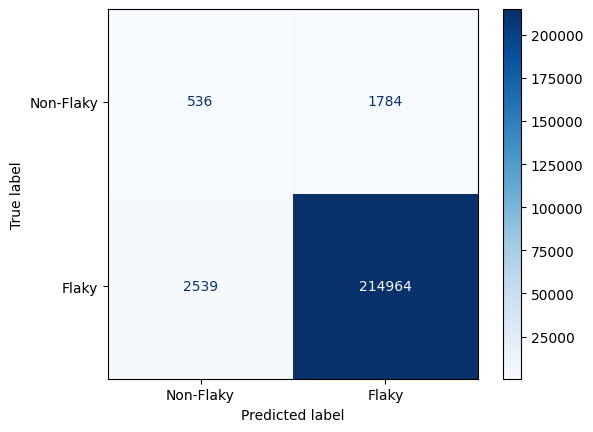

In [7]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Confusion matrix
metrics.plot_confusion_matrix(pipe, X_test, y_test, normalize=None, cmap='Blues', 
                              display_labels=["Non-Flaky", "Flaky"], values_format = '.0f')
plt.show()

In [14]:
import numpy as np

# Information about false positives
fp = np.logical_and(y_test != y_pred, y_pred == 1)
tn = np.logical_and(y_test == y_pred, y_test == 0)
fn = np.logical_and(y_test != y_pred, y_pred == 0)
tp = np.logical_and(y_test == y_pred, y_test == 1)

X_fp = X_test[fp]
X_tn = X_test[tn]
X_fn = X_test[fn]
X_tp = X_test[tp]

data_fp = dataTest.loc[X_fp.index]
data_fn = dataTest.loc[X_fn.index]
data_tp = dataTest.loc[X_tp.index]
data_tn = dataTest.loc[X_tn.index]

data_fp_fr0 = data_fp[data_fp["flakeRate"] > 0]

print("Number of FP:", len(X_fp))
print("Number of TN:", len(X_tn))
print("Number of FP with flake Rate > 0:", len(data_fp_fr0))
print("FPR:", len(X_fp) / (len(X_fp) + len(X_tn)))

Number of FP: 1784
Number of TN: 536
Number of FP with flake Rate > 0: 520
FPR: 0.7689655172413793


In [15]:
############ DISCUSSION ABOUT RQ1 ############# 

In [16]:
# keep probabilities for the positive outcome only
yhat = pipe.predict_proba(X_test)
probs = yhat[:, 1]

# Create a dataframe with probabilities and indexes
df = pd.DataFrame(yhat, index=X_test.index)

u = df.join(X_tp).dropna(subset=['runDuration'])
u["class"] = "TP"
v = df.join(X_tn).dropna(subset=['runDuration'])
v["class"] = "TN"
w = df.join(X_fp).dropna(subset=['runDuration'])
w["class"] = "FP"
x = df.join(X_fn).dropna(subset=['runDuration'])
x["class"] = "FN"

# merged_df = pd.concat([u, v, w, x], axis=1)
merged_df = pd.concat([u, v, w, x], ignore_index=False)
merged_df.columns = merged_df.columns.map(str)

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.7s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.8s finished


In [17]:
import seaborn as sn
%matplotlib qt 
# LinePlot for Model Confidence approach, missed faults and false alerts

# Create pandas dataframe
df = pd.DataFrame(columns = ['trust', 'type', "number"])
df = pd.concat([df, pd.DataFrame([{"trust": 100, "type": "Model confidence - Missed faults", "number": 1768}])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([{"trust": 0, "type": "Model confidence - Missed faults", "number": 0}])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([{"trust": 100, "type": "Model confidence - False alerts", "number": 2435}])], ignore_index=True)
df = pd.concat([df, pd.DataFrame([{"trust": 0, "type": "Model confidence - False alerts", "number": 0}])], ignore_index=True)

# Loop for each step
for trustLevel in range(1,100):
    
    nbFailures = len(merged_df)

    nbFailuresToPick = int(nbFailures * trustLevel / 100)

    topPositiveElements = merged_df.nlargest(nbFailuresToPick, '1')
    topNegativeElements = merged_df.nsmallest(nbFailuresToPick, '0')

    fp = len(topPositiveElements[topPositiveElements["class"] == "FP"])
    fn = len(topNegativeElements[topNegativeElements["class"] == "FN"])

    df = pd.concat([df, pd.DataFrame([{"trust": trustLevel, "type": "Model confidence - Missed faults", "number": fp}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{"trust": trustLevel, "type": "Model confidence - False alerts", "number": fn}])], ignore_index=True)

dataModelFPFN = df

In [18]:
# Random approach

# Set of flaky and faulty in test set
testSetFlaky = dataTest[dataTest["label"] == 1]
testSetFaulty = dataTest[dataTest["label"] == 0]

# Total failures
print(len(testSetFlaky))
print(len(testSetFaulty))

# Unique tests
r = testSetFlaky.drop_duplicates(subset=["testId", "buildId"])
print("Unique flaky tests:", len(r))

s = testSetFaulty.drop_duplicates(subset=["testId", "buildId"])
print("Unique Fault-revealing tests:", len(s))

avgFlakyReruns = len(testSetFlaky) / len(r)
avgFaultyReruns = len(testSetFaulty) / len(s)

print("Average rerun for flaky tests:", avgFlakyReruns)
print("Average rerun for faulty tests:", avgFaultyReruns)

avgReruns = len(r) + len(s)
avgTimeReruns = len(r) * 5.07 + len(s) * 3.94

print("Average reruns:", avgReruns)
print("Average rerun time:", avgTimeReruns)

dataRandomRerunsTime = pd.DataFrame(columns = ['trust', 'reruns', 'time'])
dataRandomRerunsTime = pd.concat([dataRandomRerunsTime, pd.DataFrame([{"trust": 0, "reruns": avgReruns, "time": avgTimeReruns/3600}])], ignore_index=True)
dataRandomRerunsTime = pd.concat([dataRandomRerunsTime, pd.DataFrame([{"trust": 100, "reruns": 0, "time": 0}])], ignore_index=True)
dataRandomRerunsTime['reruns'] = dataRandomRerunsTime['reruns'].astype(float)
dataRandomRerunsTime['time'] = dataRandomRerunsTime['time'].astype(float)

pprint(dataRandomRerunsTime)

217503
2320
Unique flaky tests: 211296
Unique Fault-revealing tests: 580
Average rerun for flaky tests: 1.0293758518855065
Average rerun for faulty tests: 4.0
Average reruns: 211876
Average rerun time: 1073555.92
  trust    reruns        time
0     0  211876.0  298.209978
1   100       0.0    0.000000


In [19]:
from numpy.random import choice

nbFP = len(data_fp)
nbFN = len(data_fn)
nbTP = len(data_tp)
nbTN = len(data_tn)

def effectivenessTrustRandom(step):

    # TN, FP, FN, TP or Faults correctly identified, Missed faults, False alerts, Flaky correctly identified
    conf_matrix = [nbTN, nbFP, nbFN, nbTP]
    print(conf_matrix)

    nbFailures = 219823
    probas = [nbTN/nbFailures, nbFP/nbFailures, nbFN/nbFailures, nbTP/nbFailures]

    # Create pandas dataframe
    df = pd.DataFrame(columns = ['trust', 'type', 'number'])
    df = pd.concat([df, pd.DataFrame([{"trust": 100, "type": "Random - Missed faults", "number": nbFP}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{"trust": 0, "type": "Random - Missed faults", "number": 0}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{"trust": 100, "type": "Random - False alerts", "number": nbFN}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{"trust": 0, "type": "Random - False alerts", "number": 0}])], ignore_index=True)

    # Loop for each step
    for trustLevel in range(1,step):
        # Loop for each step, do 30 times
        for j in range(0,30):

            nbFailuresToPick = int(nbFailures * trustLevel / 100)
            randomNumberList = choice(conf_matrix, nbFailuresToPick, p=probas)
    
            unique, counts = np.unique(randomNumberList, return_counts=True)
            d = dict(zip(unique, counts))

            tn = d[nbTN]
            fp = d[nbFP]
            tp = d[nbTP]
            fn = d[nbFN]

            df = pd.concat([df, pd.DataFrame([{"trust": trustLevel, "type": "Random - Missed faults", "number": fp}])], ignore_index=True)
            df = pd.concat([df, pd.DataFrame([{"trust": trustLevel, "type": "Random - False alerts", "number": fn}])], ignore_index=True)     

    return df
dataRandomFPFN = effectivenessTrustRandom(100)
dataModelRandomFPFN = pd.concat([dataRandomFPFN, dataModelFPFN], ignore_index=True)
dataModelRandomFPFN['number'] = dataModelRandomFPFN['number'].astype(float)

[536, 1784, 2539, 214964]


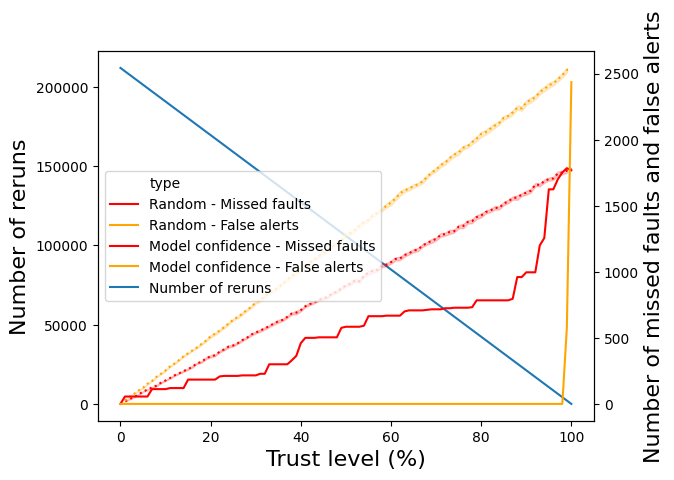

In [20]:
# PLOTS

%matplotlib inline

# Define the colors for each hue
colors = ['red', 'orange', 'red', 'orange']

ax1 = sn.lineplot(x="trust", y="reruns", data=dataRandomRerunsTime)
ax1.set_xlabel('Trust level (%)', fontsize=16)
ax1.set_ylabel('Number of reruns', fontsize=16)

ax = ax1.twinx()

ax = sn.lineplot(x="trust", y="number", hue="type",
         data=dataModelRandomFPFN, palette=colors)
ax.set_xlabel('Trust level (%)', fontsize=16)
ax.set_ylabel('Number of missed faults and false alerts', fontsize=16)
ax.lines[0].set_linestyle(":")
ax.lines[1].set_linestyle(":")

lines, labels = ax.get_legend_handles_labels()
lines.append(ax1.lines[0])
labels.append('Number of reruns')

# Display the legend
plt.legend(lines, labels, loc='center left')
plt.show()
